In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pip install facenet_pytorch

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from PIL import Image, ImageDraw
from IPython import display
import numpy as np
import os

In [ ]:
data_dir = 'data/pt'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

frames_tracked = []
for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    for img in x:
        boxes, _ = mtcnn.detect(img)
    
        # Draw faces
        frame_draw = img.copy()
        draw = ImageDraw.Draw(frame_draw)
        for box in boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)

        # Add to frame list
        frames_tracked.append(frame_draw)
    
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

Batch 1 of 1

In [ ]:
for i, (x, y) in enumerate(loader):
    print(x)
    print(y)

[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F4FB3B96470>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F4FB3B96518>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F4FB3B96390>]
['data/pt_cropped/face/1.jpg', 'data/pt_cropped/face/2.jpg', 'data/pt_cropped/face/3.jpg']


In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(x)
    print(y)

tensor([[[[ 0.3477,  0.2227,  0.1367,  ...,  0.3789,  0.4180,  0.4336],
          [ 0.3086,  0.2305,  0.1367,  ...,  0.3633,  0.4102,  0.4414],
          [ 0.2617,  0.2148,  0.1055,  ...,  0.3398,  0.3945,  0.4336],
          ...,
          [ 0.1523, -0.0430, -0.1523,  ...,  0.1992,  0.2305,  0.2070],
          [ 0.1445, -0.0195, -0.1289,  ...,  0.2852,  0.2930,  0.2148],
          [ 0.1133, -0.0117, -0.1211,  ...,  0.3320,  0.3398,  0.2461]],

         [[-0.0273, -0.1367, -0.2227,  ...,  0.0352,  0.0742,  0.0898],
          [-0.0664, -0.1289, -0.2227,  ...,  0.0195,  0.0664,  0.0977],
          [-0.1133, -0.1445, -0.2539,  ..., -0.0039,  0.0508,  0.0898],
          ...,
          [-0.2852, -0.4648, -0.5742,  ..., -0.2461, -0.2305, -0.2461],
          [-0.2930, -0.4570, -0.5508,  ..., -0.1758, -0.1602, -0.2383],
          [-0.3242, -0.4492, -0.5430,  ..., -0.1289, -0.1133, -0.2305]],

         [[-0.2070, -0.3242, -0.4023,  ..., -0.1758, -0.1367, -0.1211],
          [-0.2461, -0.3164, -

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     1/1    | loss:    0.0000 | fps:    0.4593 | acc:    1.0000   

Epoch 1/8
----------
Train |     1/1    | loss:    0.0000 | fps:    3.2997 | acc:    1.0000   
Valid |     1/1    | loss:    0.0000 | fps:    1.9483 | acc:    1.0000   

Epoch 2/8
----------
Train |     1/1    | loss:    0.0000 | fps:    3.2696 | acc:    1.0000   
Valid |     1/1    | loss:    0.0000 | fps:    1.9557 | acc:    1.0000   

Epoch 3/8
----------
Train |     1/1    | loss:    0.0000 | fps:    3.3872 | acc:    1.0000   
Valid |     1/1    | loss:    0.0000 | fps:    1.8828 | acc:    1.0000   

Epoch 4/8
----------
Train |     1/1    | loss:    0.0000 | fps:    3.1077 | acc:    1.0000   
Valid |     1/1    | loss:    0.0000 | fps:    1.9044 | acc:    1.0000   

Epoch 5/8
----------
Train |     1/1    | loss:    0.0000 | fps:    3.3752 | acc:    1.0000   
Valid |     1/1    | loss:    0.0000 | fps:    1.9314 | acc:    1.0000   

Epoch 6/8
----------
Train |     1/1    | loss:    0.0

In [ ]:
print(frames_tracked)

[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F4FB3BA54E0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F4FB3BA57F0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F4FB3BA56A0>]


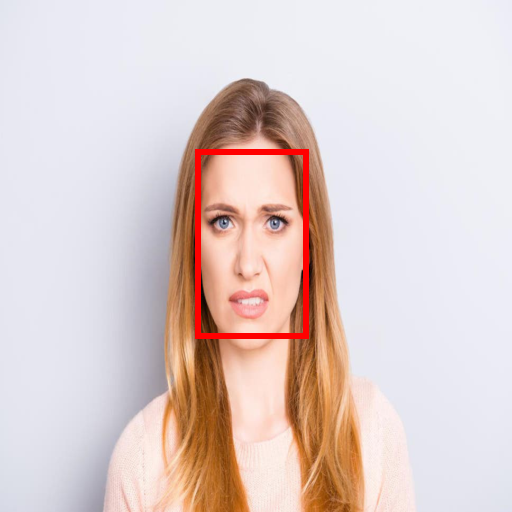

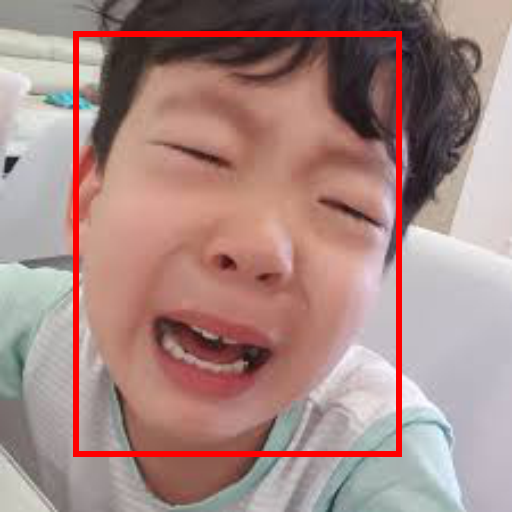

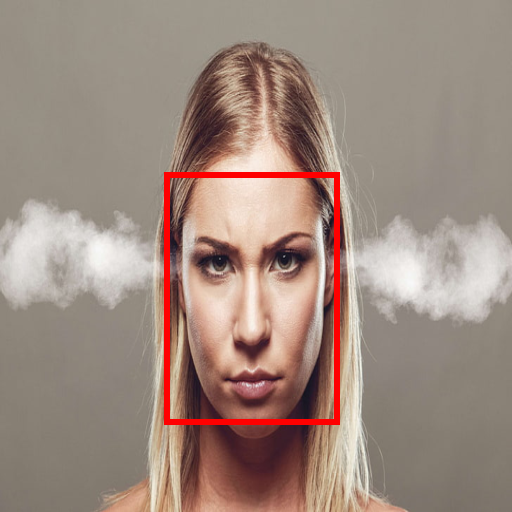

In [ ]:
for i, im in enumerate(frames_tracked):
    im.save('data/pt_result/img{:03}.jpg'.format(i))
    display.display(im)

In [ ]:
from torchvision import models
import torch.nn as nn

checkpoint = torch.load("result/fer_best_model.pt")

model= models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
model = model.to(device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

dataset = datasets.ImageFolder("data/pt_cropped",
                               transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean_nums, std_nums)]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)

In [ ]:
model.eval()
answer = []
for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    answer.extend(preds.cpu().clone().numpy())

In [ ]:
emo = []
for a in answer:
    if a == 0:
        emo.append("angry")
        print(emo[-1])
    elif a == 1:
        emo.append("disgsted")
        print(emo[-1])
    elif a == 2:
        emo.append("fearful")
        print(emo[-1])
    elif a == 3:
        emo.append("happy")
        print(emo[-1])
    elif a == 4:
        emo.append("neutral")
        print(emo[-1])
    elif a == 5:
        emo.append("sad")
        print(emo[-1])
    elif a == 6:
        emo.append("surpirsed")
        print(emo[-1])
    else:
        emo.append("unknown")
        print(emo[-1])

fearful
sad
sad


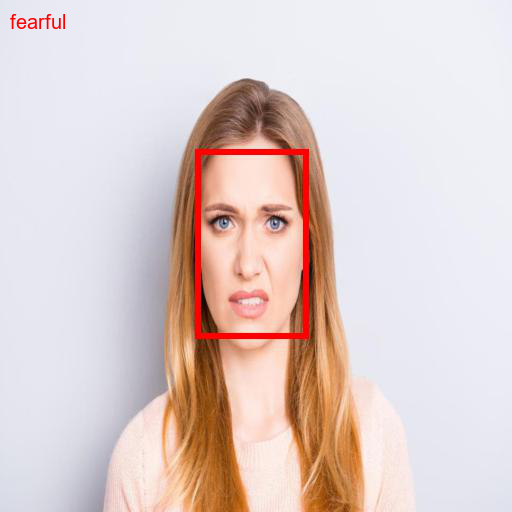

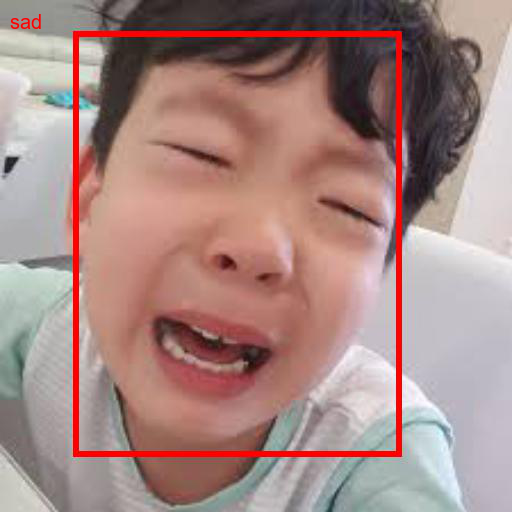

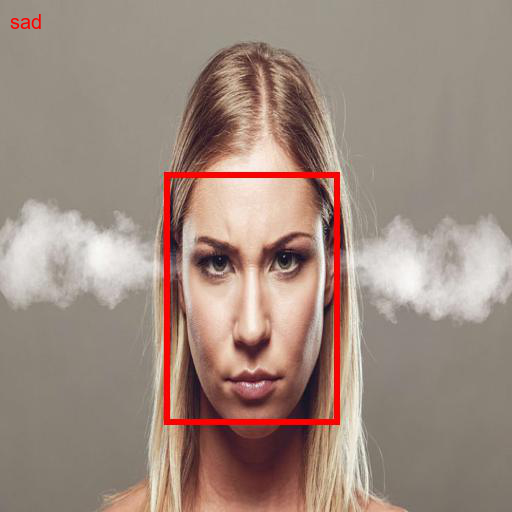

In [ ]:
from PIL import ImageFont

for i, txt in enumerate(emo):
    img = Image.open('data/pt_result/img{:03}.jpg'.format(i))
    d = ImageDraw.Draw(img)
    fnt = ImageFont.truetype("data/arial.ttf", 20)
    d.text((10,10), emo[i], font=fnt, fill=(255,0,0))
    img.save('data/pt_result/img_emo{:03}.jpg'.format(i))
    display.display(img)